# 0.Assignments

👾 這個陽春的聊天機器人需要被優化！<br>
若是一個對話串不間斷地持續進行，送進去的訊息量會很多，tokens數量也會跟著增加，會需要花比較多費用(💸💸💸)，也可能使模型的回應雜訊比較多而回應受到干擾，所以我們可以優化短期記憶。<br>
另外，我們希望優化使用者體驗，我們可以根據聊天的內容整理出使用者的屬性，並在每一次跟使用者聊天時，都能根據這個使用者的狀況給予客製化的回應，因此我們要加入長期記憶的功能！

<br>

### 1. 短期記憶優化

(1) 🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)


<br>

### 2. 加入長期記憶

加入長期記憶，讓聊天機器人能夠記住使用者的資訊（名字、偏好語言、興趣），在下一次對話也能針對同個使用者的資訊，給予個人化的回答。

(1) 🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>


(2) 👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)
<br>
備註：基本版是需要大家完成的，進階版可以自行決定是否挑戰，Enjoy the ride! 😎

# 1.短期記憶

## (1) 基本版
🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)

note: 可以邊做邊看一下trim設定的效果以及內部運作的機制

In [ ]:
%%capture --no-stderr
!pip install -U langgraph langchain_openai==0.3.15 langchain transformers bitsandbytes langchain-huggingface


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 會需要一點時間
# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/911k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.60G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/508M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

# 包裝成 LangChain 的 llm 物件
llm = HuggingFacePipeline(pipeline=generator)

Device set to use cuda:0


In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

from langgraph.checkpoint.memory import MemorySaver


from langchain_core.runnables import RunnableLambda
from langchain_core.messages import BaseMessage
from langchain_core.messages.utils import trim_messages

MAX_TOKENS = 2048  # 你可以根據模型實際容量調整


class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(state: State):
    # 取得對話訊息
    messages: list[BaseMessage] = state["messages"]

    # 修剪訊息，如果 token 超過上限
    trimmed_messages = trim_messages(messages, max_tokens=MAX_TOKENS, tokenizer=tokenizer)

    # 丟進 llm 做回應
    response = llm.invoke(trimmed_messages)

    # 回傳新的 state（原訊息 + 回應）
    return {"messages": messages + [AIMessage(content=response)]}

def estimate_tokens(msgs):
    total_tokens = 0
    for m in msgs:
        role = m["role"]
        content = m["content"]
        tokenized = tokenizer.encode(f"{role}: {content}", add_special_tokens=False)
        total_tokens += len(tokenized)
    return total_tokens




# def chatbot(state: State):
  # 💻code below:
  # hint: you can use langchain_core trim_messages function to trim your trim_messages, and count_tokens_approximately to count tokens



# 建立graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot) # 在graph裡面加入chatbot的node
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 加入短期記憶
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


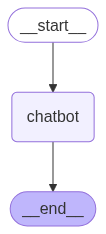

In [ ]:
# 看一下graph
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [ ]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
      if "chatbot" in event:
        for value in event.values():
          print("Assistant:", value["messages"][-1].content)

In [ ]:
# 設定對話config (第一次對話)
config = {"configurable": {"thread_id": "conversation_1"}} # thread_id: 對話id

In [28]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: hi
BaseStore.get() missing 1 required positional argument: 'key'


---

# 2.長期記憶

## (1) 基本版
🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>

In [21]:
%%capture --no-stderr
!pip install langchain_core

In [36]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver # within-thread memory
from langgraph.store.memory import InMemoryStore # cross-thread store

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


class State(TypedDict):
  messages: Annotated[list, add_messages]

#def chatbot(__________):
  # 💻code here:
  # TODO:
  # 依據user_id取得長期記憶
  # 將長期記憶也放進system prompt中，讓llm可以個人化回覆
def chatbot(state: State, config: dict):
    user_id = config["configurable"]["user_id"]

    # 🚩取得長期記憶
    print("get user_profile")
    user_profile = store.search(user_id) or "（尚未有使用者資訊）"
    print("end get user_profile")

    # 🚩簡易 trim：只保留最近的 N 則訊息
    trimmed_messages = state["messages"][-6:]  # 假設只保留最後 6 則訊息

    # 🚩組 prompt：加入 system prompt
    messages = [SystemMessage(content=f"你是一個貼心助理。根據以下使用者資訊給予個人化回覆：\n{user_profile}")]
    messages.extend(trimmed_messages)

    # 🚩呼叫 LLM
    response = llm.invoke(messages)

    return {"messages": [AIMessage(content=response.content)]}

  #return {"messages": [AIMessage(content=response)]}


#def write_memory(________):
  # 💻code here:
  # TODO:
  # 將使用者的對話整理成要儲存成長期記憶的資訊，並存入長期記憶

def write_memory(state: State, config: dict):
    user_id = config["configurable"]["user_id"]

    history = state["messages"][-2:]  # 最近一次回合 [user, ai]
    formatted_history = "\n".join([f"{msg.type.capitalize()}: {msg.content}" for msg in history])

    summary_prompt = ChatPromptTemplate.from_messages([
        ("system", "你是負責整理使用者特徵的助理，請根據對話描述使用者的喜好、需求、個性或關鍵背景資訊。請使用第三人稱書寫，語氣簡潔清楚。"),
        ("user", "{dialogue}")
    ])
    summarize_chain = summary_prompt | llm | StrOutputParser()

    new_summary = summarize_chain.invoke({"dialogue": formatted_history})
    existing = store.search(user_id)
    updated_memory = (existing or "") + "\n" + new_summary
    store.set(user_id, updated_memory)

    return {}

# Define the graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)


# Compile the graph with the checkpointer fir and store

# 💻Code Here
# 記得放入短期記憶，長期記憶的store
memory = MemorySaver()  # 短期記憶（thread）
store = InMemoryStore()  # 長期記憶（跨 thread、依 user_id）

graph = builder.compile(checkpointer=memory, store=store)


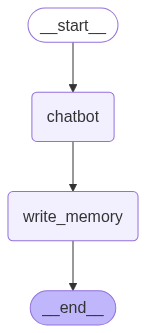

In [37]:
# View
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [38]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
              print("Assistant:", value["messages"][-1].content)

In [39]:
# 使用者A的第一次對話
config = {"configurable": {"thread_id": "conversation_1", "user_id": "user_a"}}

In [40]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input =
    input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: hi
get user_profile
end get user_profile


/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:463: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


'str' object has no attribute 'content'


In [ ]:
# 使用者A的第二次對話
config = {"configurable": {"thread_id": "conversation_2", "user_id": "user_a"}}

In [ ]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

## (2) 進階版

👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)

In [ ]:
# 💻code here, enjoy the ride 😎
